In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A lot of the preprocessing code that we use is convoluted and hard to understand, so we compiled it into one function call (make_dataset_VOC) and included it all into one file that we download below.

In [0]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/lshalon/CSE514CourseProject/master/caching_and_preprocessing.py', 'caching_and_preprocessing.py')
from caching_and_preprocessing import *

In [0]:
!cp '/content/drive/My Drive/514project/VOCtrainval_11-May-2012.tar' '/content/' 
!tar -xf '/content/VOCtrainval_11-May-2012.tar'

In [5]:
make_dataset_VOC()

KeyboardInterrupt: ignored

In [0]:
import random

In [0]:
def image_segmentation_generator(batch_size, valid=False, logging=False):
  image_paths = "/content/VOCdevkit/VOC2012/{}/imgs/".format('val' if valid else 'train')
  seg_paths = "/content/VOCdevkit/VOC2012/{}/segs/".format('val' if valid else 'train')
  
  img_seg_pairs = get_pairs_from_paths(image_paths, seg_paths)
  random.Random(4).shuffle(img_seg_pairs)
  
  if logging:
    print(image_paths)
    print('samples in {} ds {}'.format('val' if valid else 'train', len(img_seg_pairs)))
 
  zipped_paths = itertools.cycle(img_seg_pairs)
 
  while True:
    X, Y = [], []

    for _ in range(batch_size) :
      img, seg = next(zipped_paths) 
   
      img = cv2.resize(cv2.imread(img, 1), (128, 128)).astype(np.float32)
      img /= 255.0
      X.append(img)
	 
      seg = cv2.resize(cv2.imread(seg, 1), (128, 128), interpolation=cv2.INTER_NEAREST)[:, : , 0]
      seg_labels = np.zeros((128, 128, 21))
      for c in range(21):
        seg_labels[:, :, c] = (seg == c).astype(int)
		
      Y.append(seg_labels)

    yield np.array(X) , np.array(Y)

In [0]:
# note that val ds has 1449 samples, train has 1464

## Visualization for sanity checks

In [0]:
# get the image of the labels
def LayersToRGBImage(pred):

    label_mask=np.argmax(pred, axis=-1)
    label_colours = np.asarray(
            [
                [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0],  [0, 192, 0], [128, 192, 0],
                [0, 64, 128],
            ]
        )
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, 21):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [0]:
import matplotlib.pyplot as plt

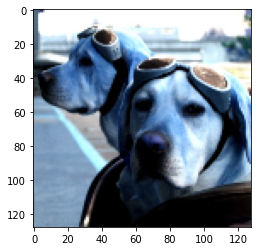

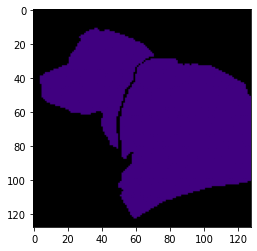

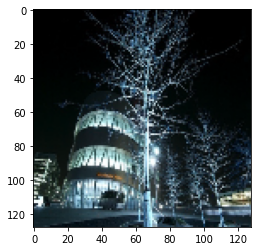

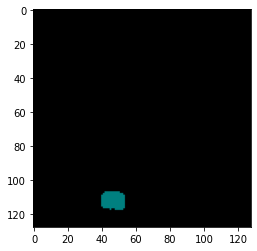

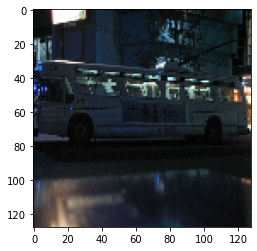

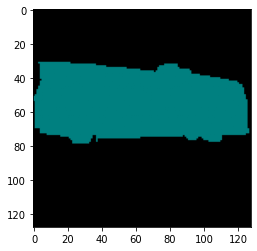

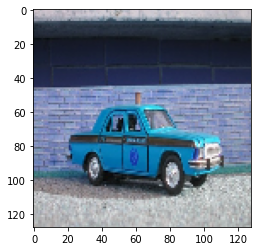

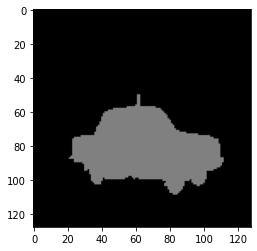

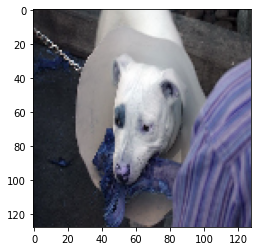

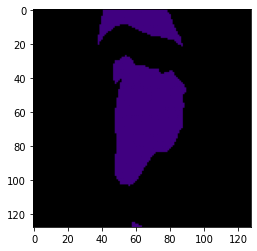

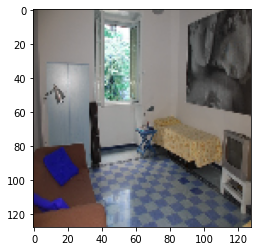

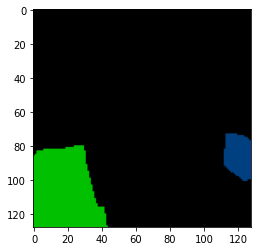

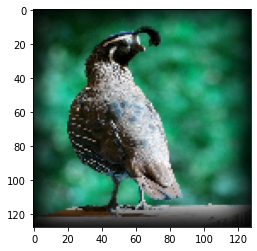

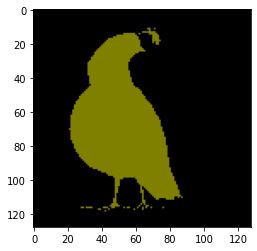

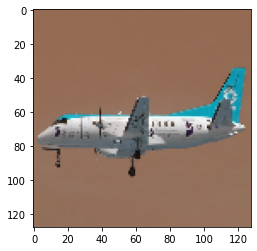

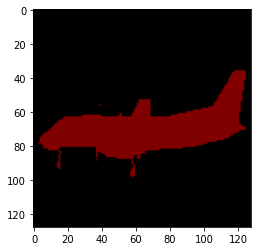

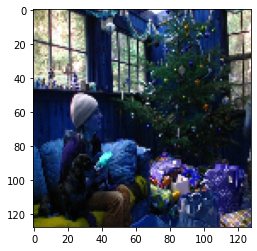

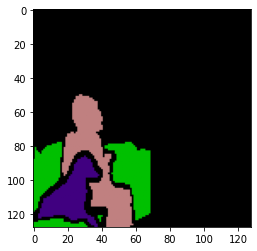

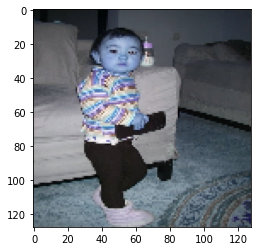

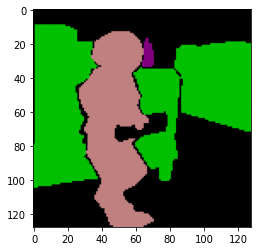

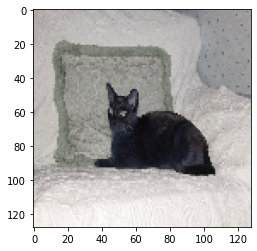

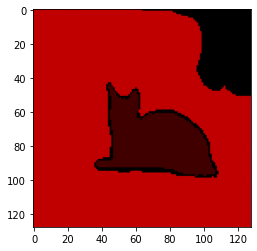

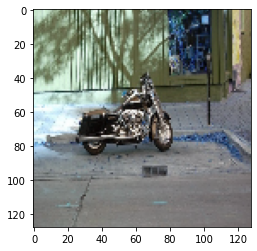

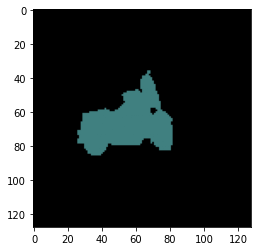

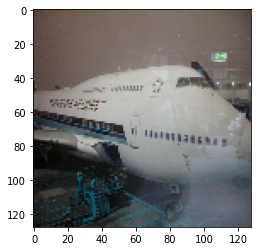

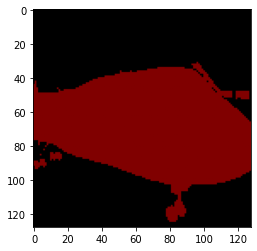

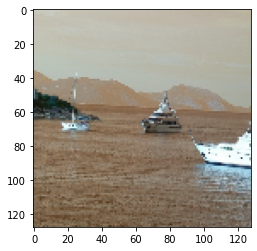

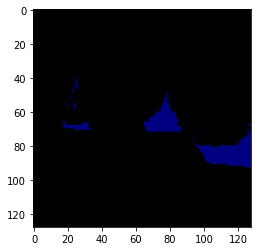

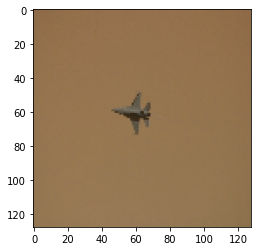

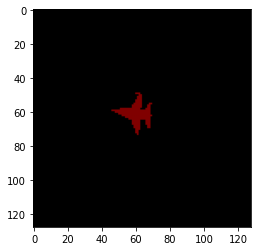

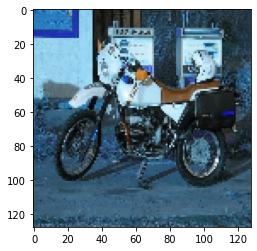

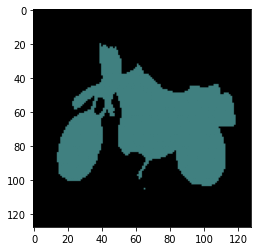

In [11]:
(x, y) = next(image_segmentation_generator(16))
for i in range(len(x)):
  plt.imshow(x[i])
  plt.show()
  plt.imshow(LayersToRGBImage(y[i]))
  plt.show()

## Models

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.regularizers import l2
import keras.backend as K

Using TensorFlow backend.


In [0]:
def FCN(weight_decay=0., batch_momentum=0.9, classes=21):
    img_input = Input(shape=(128, 128, 3))
    #image_size = input_shape[0:2]
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(1024, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(1024, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.2)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = UpSampling2D(size=(16, 16))(x)
    x = (Activation('softmax'))(x)

    model = Model(img_input, x)

    return model

In [0]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    conv = Dropout(0.1)(conv)
    
    return conv
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    k_size = 3
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c
def ResUNet(img_h=128, img_w=128):
    f = [64, 128, 256, 512, 1024,2048]
    inputs = Input((img_h, img_w, 3))
  
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    e6 = residual_block(e5, f[5], strides=2)
    
    ## Bridge
    b0 = conv_block(e6, f[5], strides=1)
    b1 = conv_block(b0, f[5], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e5)
    d1 = residual_block(u1, f[5])
    
    u2 = upsample_concat_block(d1, e4)
    d2 = residual_block(u2, f[4])
    
    u3 = upsample_concat_block(d2, e3)
    d3 = residual_block(u3, f[3])
    
    u4 = upsample_concat_block(d3, e2)
    d4 = residual_block(u4, f[2])

    u5 = upsample_concat_block(d4, e1)
    d5 = residual_block(u5, f[1])
    
    outputs = tf.keras.layers.Conv2D(21, (1, 1), padding="same", activation="softmax")(d4)
    outputs = UpSampling2D(size=(2, 2))(outputs)

    model = tf.keras.models.Model(inputs, outputs)
    return model

In [0]:
#building U-NET
def unet():
  inputs = Input((128, 128, 3))

  c1 = Conv2D(64,(3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = BatchNormalization()(c1)
  c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = BatchNormalization()(c2)
  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = BatchNormalization()(c3)
  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = BatchNormalization()(c4)
  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p4)
  c5 = BatchNormalization()(c5)
  c5 = Conv2D(1024, (3, 3), activation='relu',  padding='same') (c5)
  c5 = BatchNormalization()(c5)

  u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(512, (3, 3), activation='relu',  padding='same') (u6)
  c6 = Conv2D(512, (3, 3), activation='relu',  padding='same') (c6)

  u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(256, (3, 3), activation='relu',  padding='same') (u7)
  c7 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c7)

  u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u8)
  c8 = Conv2D(128,(3, 3), activation='relu', padding='same') (c8)

  u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(64,(3, 3), activation='relu',  padding='same') (u9)
  c9 = Conv2D(64,(3, 3), activation='relu',  padding='same') (c9)

  outputs = Conv2D(21, (1, 1), activation='softmax') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [0]:
# image ordering = 'channels_last'
# -1 = -1

#building pspnet
def vanilla_encoder(input_height=128,  input_width=128):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    img_input = Input(shape=(input_height, input_width, 3))

    image_input = Input((128, 128, 3));
    x = img_input
    levels = []

    x = (ZeroPadding2D((pad, pad), data_format='channels_last'))(x)
    x = (Conv2D(filter_size, (kernel, kernel),
                data_format='channels_last', padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format='channels_last'))(x)
    levels.append(x)

    x = (ZeroPadding2D((pad, pad), data_format='channels_last'))(x)
    x = (Conv2D(128, (kernel, kernel), data_format='channels_last',
         padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format='channels_last'))(x)
    levels.append(x)

    for _ in range(3):
        x = (ZeroPadding2D((pad, pad), data_format='channels_last'))(x)
        x = (Conv2D(256, (kernel, kernel),
                    data_format='channels_last', padding='valid'))(x)
        x = (BatchNormalization())(x)
        x = (Activation('relu'))(x)
        x = (MaxPooling2D((pool_size, pool_size),
             data_format='channels_last'))(x)
        levels.append(x)

    return img_input, levels

def pool_block(feats, pool_factor):

    if 'channels_last' == 'channels_first':
        h = K.int_shape(feats)[2]
        w = K.int_shape(feats)[3]
    elif 'channels_last' == 'channels_last':
        h = K.int_shape(feats)[1]
        w = K.int_shape(feats)[2]

    pool_size = strides = [
        int(np.round(float(h) / pool_factor)),
        int(np.round(float(w) / pool_factor))]

    x = AveragePooling2D(pool_size, data_format='channels_last',
                         strides=strides, padding='same')(feats)
    x = Conv2D(512, (1, 1), data_format='channels_last',
               padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=tuple(pool_size))(x)

    return x

def _pspnet(n_classes, encoder, input_height=128, input_width=128):

    img_input, levels = encoder(
        input_height=input_height,  input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    pool_factors = [1, 2, 3, 6]
    pool_outs = [o]

    for p in pool_factors:
        pooled = pool_block(o, p)
        pool_outs.append(pooled)

    o = Concatenate(axis=-1)(pool_outs)

    o = Conv2D(512, (1, 1), data_format='channels_last', use_bias=False)(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2D(n_classes, (3, 3), data_format='channels_last',
               padding='same')(o)
    o = UpSampling2D(size=(32,32))(o)
    o = Activation('softmax')(o)

    model = Model(img_input, o)

    return model

def pspnet(n_classes,  input_height=128, input_width=128):

    model = _pspnet(n_classes, vanilla_encoder,
                    input_height=input_height, input_width=input_width)
    model.model_name = "pspnet"
    return model

## Training

In [0]:
import gc

class ShowProgress(tf.keras.callbacks.Callback):
    """
    Show prediction update - monitor so that we can see that this is hopefully improving
    """
    def __init__(self, x_to_test, y_ground_truth):
      self._x = tf.convert_to_tensor(x_to_test, dtype=tf.float32)
      self._y = tf.convert_to_tensor(y_ground_truth, dtype=tf.float32)
    
    def on_epoch_end(self, batch, logs=None):
      predictions = self.model.predict(self._x)
      print() # for better logging with keras training

      for i in range(len(self._y)):
        print('Ground truth')
        plt.imshow(LayersToRGBImage(self._y[i]))
        plt.show()
        print('Prediction')
        plt.imshow(LayersToRGBImage(predictions[i]))
        plt.show()
      gc.collect()

In [0]:
import math

def train(model, epochs=100, batch_size=16, validate=False, optimizer='adam', 
          loss='categorical_crossentropy', metrics=['accuracy', MeanIoU(21)], show_progress=False):
  
  # note that val ds has 1449 samples, train has 1464

  steps_per_epoch = math.ceil(1464 / batch_size)
  steps_per_valid_epoch = math.ceil(1449 / batch_size)

  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  train_gen = image_segmentation_generator(batch_size)

  callback_list = []
  if show_progress:
    images, labels = next(train_gen)
    callback_list = [ShowProgress(images[:1], labels[:1])]

  if validate:
    valid_gen = image_segmentation_generator(batch_size, valid=True)
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, validation_data=valid_gen, validation_steps=steps_per_valid_epoch,
                        epochs=epochs, verbose=1, callbacks=callback_list)
  else:
    history = model.fit(train_gen, steps_per_epoch, epochs=epochs, verbose=1, callbacks=callback_list)

  return model, history

In [0]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
  labels = [label for label in history.keys() if not label.startswith('val')]
  for label in labels:
    plt.plot(history[label])
    plt.plot(history['val_' + label])
    plt.title(title + " " + label)
    plt.ylabel(label)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

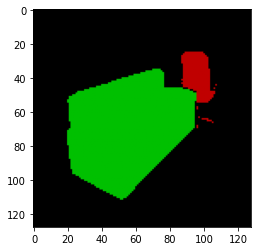

Prediction


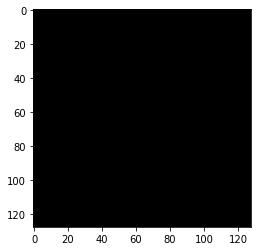

92/92 [==============================] - 65s 704ms/step - loss: 1.3692 - mean_io_u: 0.4762 - accuracy: 0.7406 - val_loss: 1.5307 - val_mean_io_u: 0.4762 - val_accuracy: 0.7480
Epoch 2/3
92/92 [==============================] - ETA: 0s - loss: 1.2638 - mean_io_u: 0.4762 - accuracy: 0.7495Batch #1
Ground truth


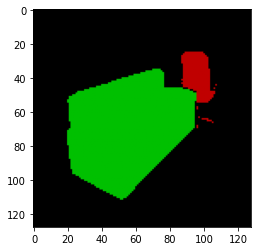

Prediction


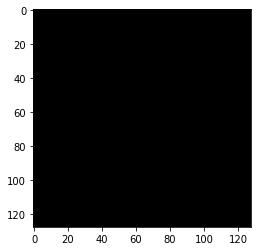

92/92 [==============================] - 63s 683ms/step - loss: 1.2638 - mean_io_u: 0.4762 - accuracy: 0.7495 - val_loss: 1.3045 - val_mean_io_u: 0.4762 - val_accuracy: 0.7482
Epoch 3/3
92/92 [==============================] - ETA: 0s - loss: 1.2202 - mean_io_u: 0.4762 - accuracy: 0.7490Batch #2
Ground truth


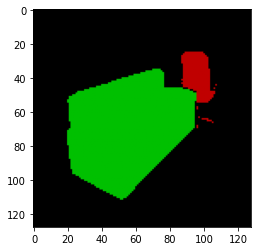

Prediction


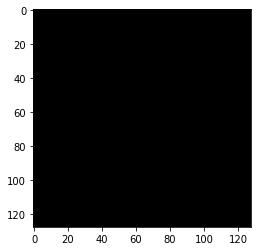

92/92 [==============================] - 63s 689ms/step - loss: 1.2202 - mean_io_u: 0.4762 - accuracy: 0.7490 - val_loss: 1.2684 - val_mean_io_u: 0.4762 - val_accuracy: 0.7478


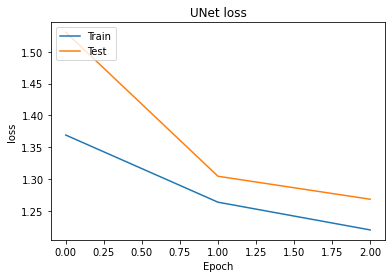

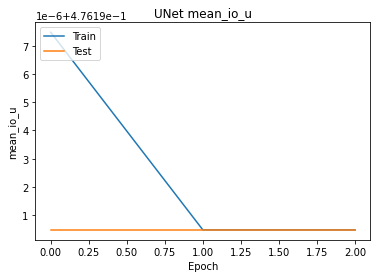

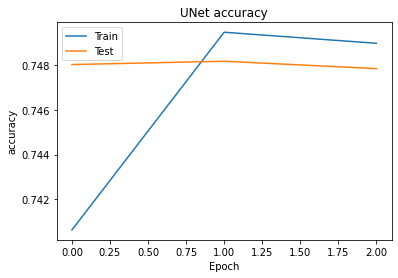

In [0]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  trained_model, history = train(unet(), optimizer=Adam(lr=1e-3, decay=0.75), epochs=3, validate=True, show_progress=True)

  plot_history(history.history, "UNet")

In [0]:
images, labels = next(image_segmentation_generator(32, logging=True))

/content/VOCdevkit/VOC2012/train/imgs/
samples in train ds 1464


Ground truth


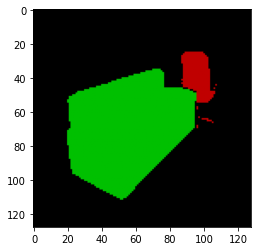

Prediction


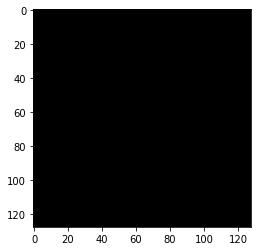

Ground truth


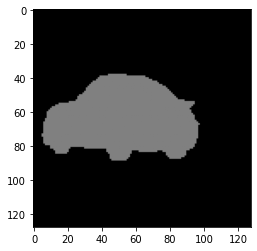

Prediction


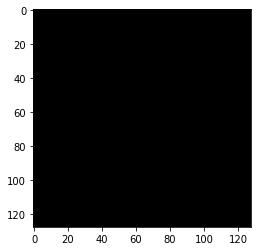

Ground truth


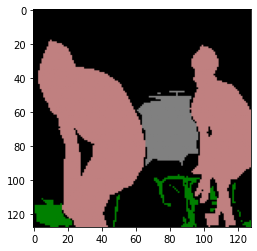

Prediction


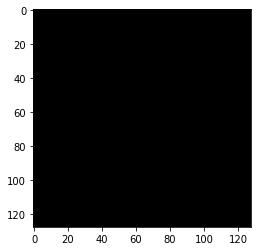

Ground truth


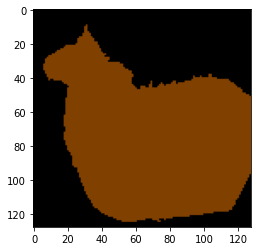

Prediction


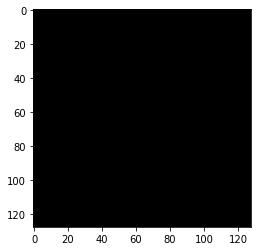

Ground truth


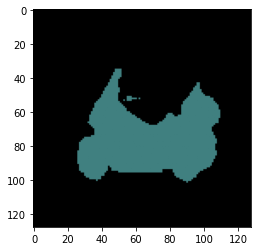

Prediction


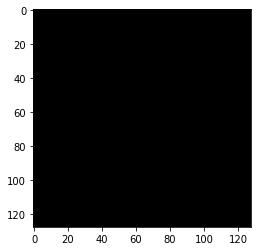

Ground truth


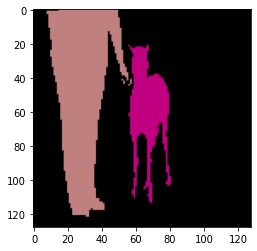

Prediction


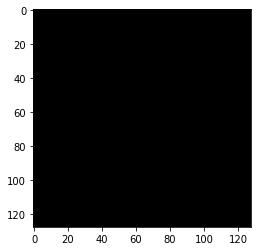

Ground truth


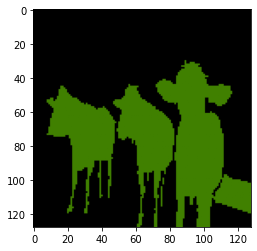

Prediction


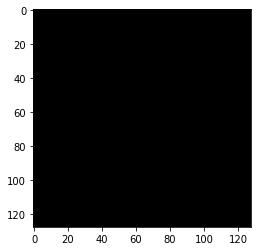

Ground truth


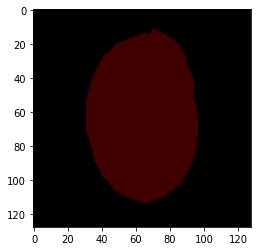

Prediction


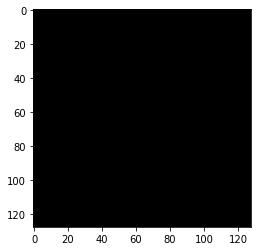

Ground truth


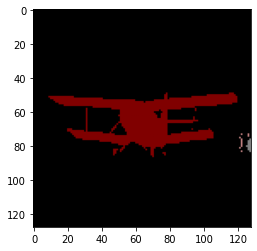

Prediction


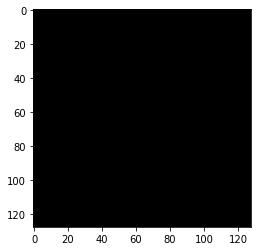

Ground truth


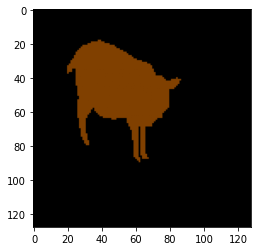

Prediction


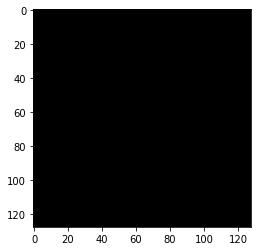

Ground truth


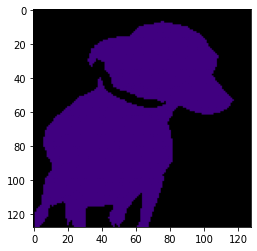

Prediction


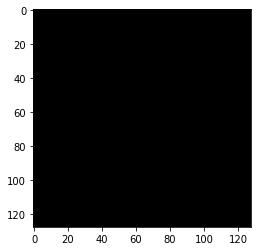

Ground truth


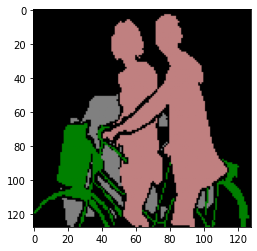

Prediction


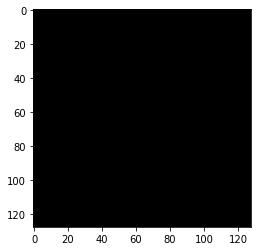

Ground truth


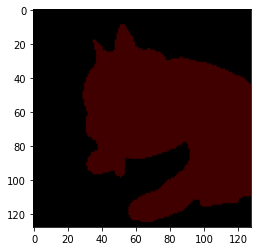

Prediction


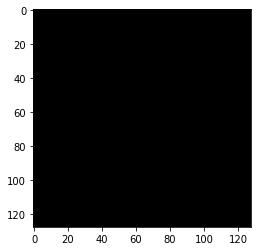

Ground truth


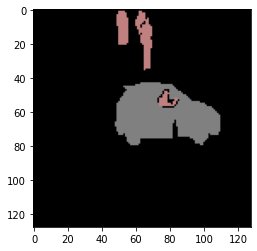

Prediction


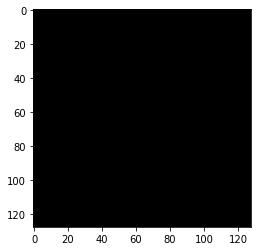

Ground truth


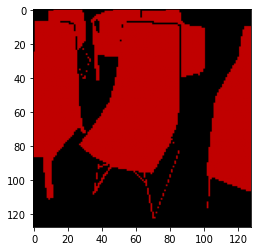

Prediction


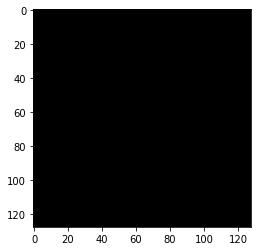

Ground truth


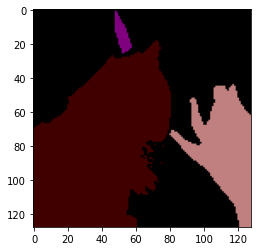

Prediction


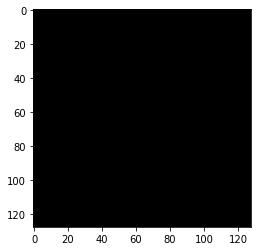

Ground truth


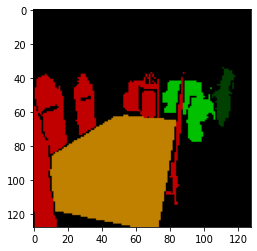

Prediction


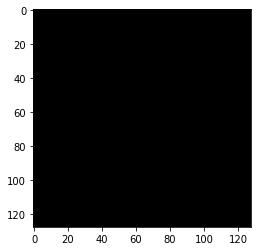

Ground truth


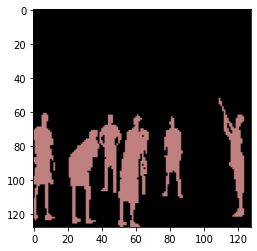

Prediction


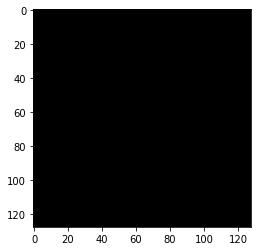

Ground truth


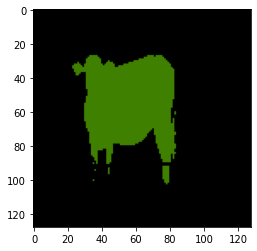

Prediction


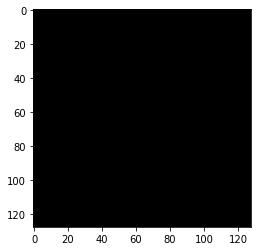

Ground truth


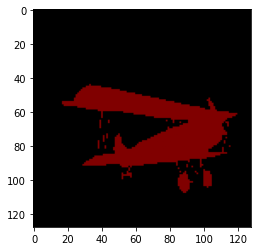

Prediction


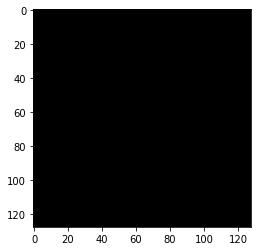

Ground truth


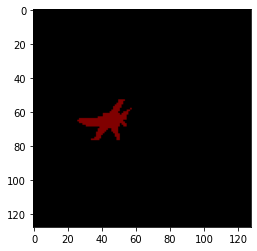

Prediction


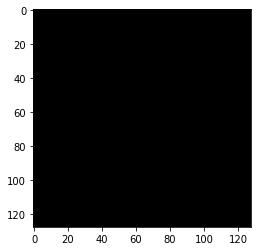

Ground truth


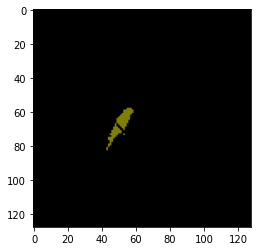

Prediction


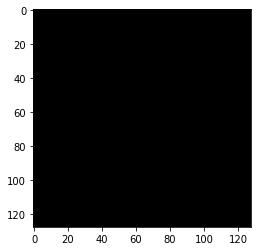

Ground truth


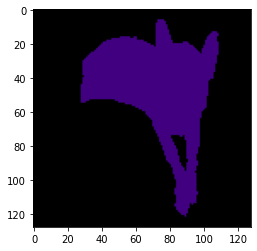

Prediction


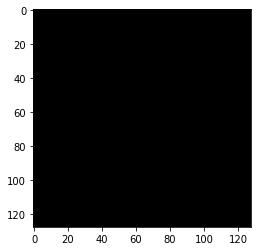

Ground truth


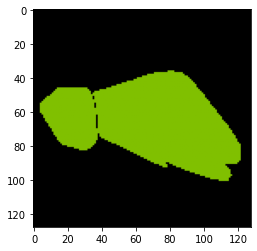

Prediction


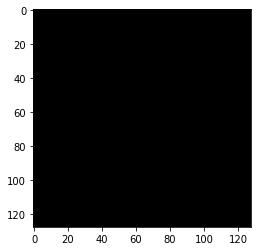

Ground truth


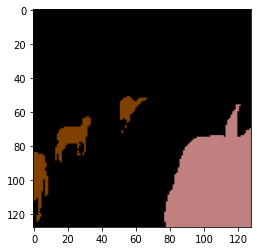

Prediction


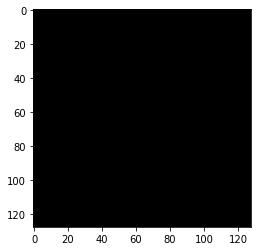

Ground truth


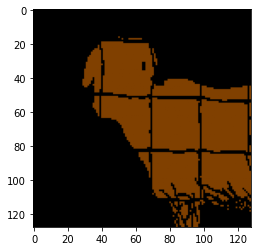

Prediction


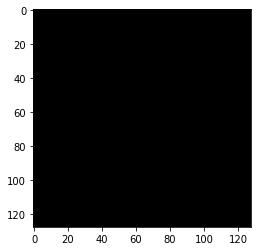

Ground truth


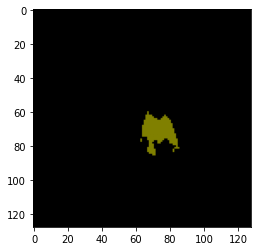

Prediction


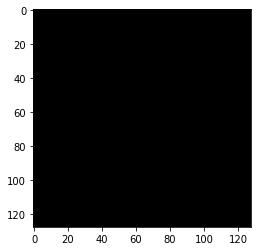

Ground truth


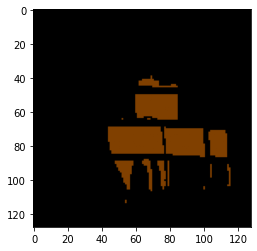

Prediction


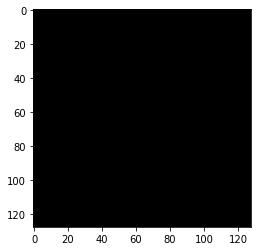

Ground truth


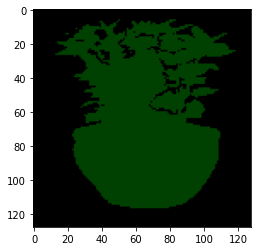

Prediction


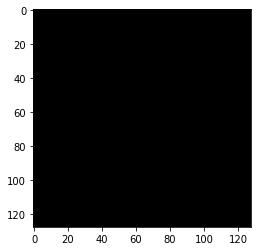

Ground truth


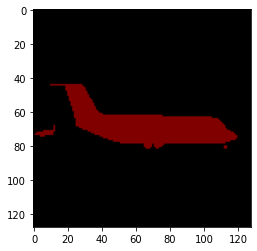

Prediction


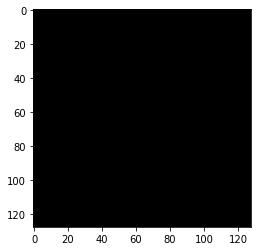

Ground truth


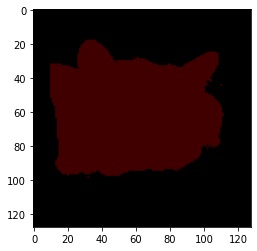

Prediction


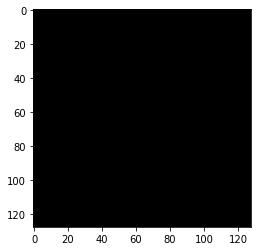

Ground truth


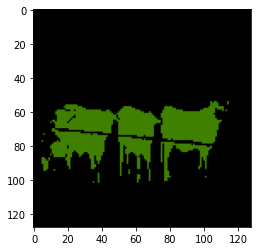

Prediction


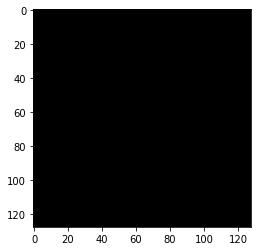

In [0]:
predictions = trained_model.predict(images)

for i in range(len(labels)):
  print('Ground truth')
  plt.imshow(LayersToRGBImage(labels[i]))
  plt.show()
  print('Prediction')
  plt.imshow(LayersToRGBImage(predictions[i]))
  plt.show()

We can see that the model is just predicting one class... the background class. That would explain why our MeanIOU doesn't quite improve. The solution is to weigh the background class less... So, before any more optimization, let's implement that weighted loss funciton.

## Weighted loss function

In [0]:
from PIL import Image

pascal_labels = np.asarray(
            [
                [0, 0, 0], [128, 0, 0],
                [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128],
                [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0],
                [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128],
                [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0],
                [0, 192, 0], [128, 192, 0],
                [0, 64, 128],
            ]
        )
n_classes = 21

# generating weights
def ClassesFromImg(img):
  colors = pascal_labels
  res = np.zeros(21, dtype=int)
  for i in range(21):
    c = img[:,:,i]
    col = colors[i]
    res[i] = np.sum(c)
  return res

def LoadDataPairs(name,path_seg="/content/VOCdevkit/VOC2012/SegmentationClass", 
                  path_img="/content/VOCdevkit/VOC2012/JPEGImages",
									width=128 , height=128 , imgNorm="divide"):

	img = cv2.imread(path_img+"/"+name+".jpg", 1)
	seg = cv2.imread(path_seg+"/"+name+".png", 1)
	# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	# seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

 	#change the seg to label
	seg = convert_VOC(seg)
	#print(seg.shape)
	seg = cv2.resize(seg, ( width , height ) , interpolation=cv2.INTER_NEAREST )
	# seg_labels = ColorsToClass(seg)
	seg = seg[:, : , 0]
	seg_labels = np.zeros((height, width, n_classes))
	for c in range(n_classes):
		seg_labels[: , : , c ] = (seg == c ).astype(int)

	#different ways to normalize the img
	if imgNorm == "non":
		img = cv2.resize(img, ( width , height ))
	if imgNorm == "sub_and_divide":
		img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
	elif imgNorm == "sub_mean":
		img = cv2.resize(img, ( width , height ))
		img = img.astype(np.float32)
		img[:,:,0] -= 103.939
		img[:,:,1] -= 116.779
		img[:,:,2] -= 123.68
		img = img[ : , : , ::-1 ]
	elif imgNorm == "divide":
		img = cv2.resize(img, ( width , height ))
		img = img.astype(np.float32)
		img = img/255.0

	return img, seg_labels
    
def weights_segmentation_generator(file_list):
  weights = np.zeros(21, dtype= int)
  for file in file_list:
    img, seg = LoadDataPairs(file)
    np.add(weights, ClassesFromImg(seg), out=weights, casting="unsafe")
  return weights

In [0]:
train_list = open("/content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt", "r").readlines()
train_list = [line[:-1] for line in train_list]
weights_per_class = weights_segmentation_generator(train_list)

128 * 128 * len(train_list)
inverse_freq_class_weights = -np.log(weights_per_class / sum(weights_per_class))

In [0]:
inverse_freq_class_weights

array([0.28863368, 4.95670203, 5.87073778, 4.80045685, 5.13925707,
       5.15700871, 4.08049685, 4.29694083, 3.66570392, 4.51656788,
       4.82497057, 4.39354329, 4.12993976, 4.72590985, 4.52394765,
       3.08712247, 5.08600918, 4.7733431 , 4.28690118, 4.18743093,
       4.75471948])

In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [0]:
inverse_freq_class_weights = -np.log(weights_per_class / sum(weights_per_class))
trained_model = None
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  weighted_loss = weighted_categorical_crossentropy(inverse_freq_class_weights)
  trained_model, history = train(unet(), optimizer=Adam(lr=1e-4, decay=1e-3), loss=weighted_loss,
                                 epochs=100, validate=True, show_progress=True)

  plot_history(history.history, "UNet")

/content/VOCdevkit/VOC2012/train/imgs/
samples in train ds 1464
Ground truth


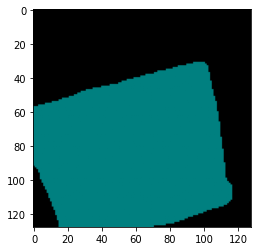

Prediction


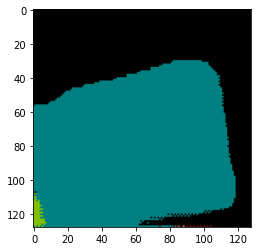

Ground truth


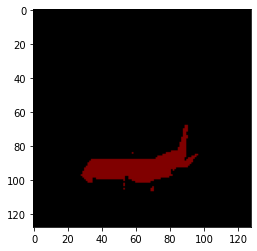

Prediction


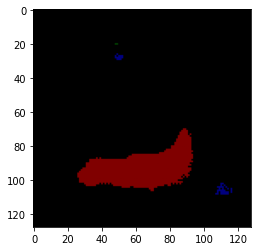

Ground truth


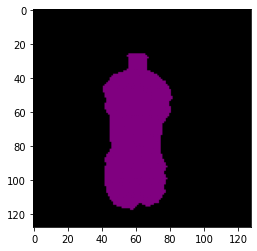

Prediction


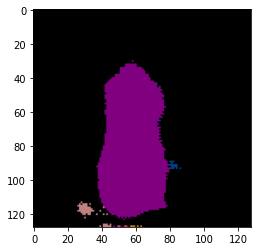

Ground truth


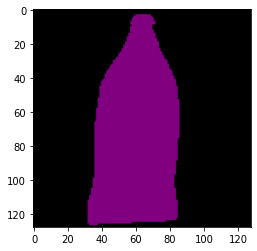

Prediction


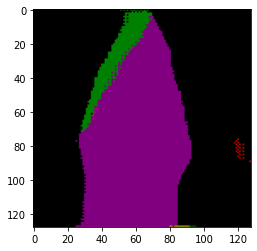

Ground truth


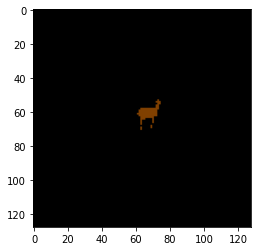

Prediction


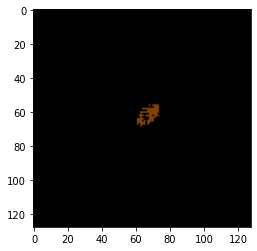

Ground truth


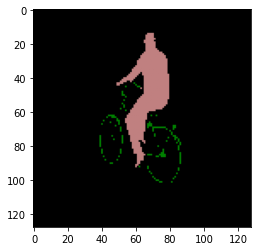

Prediction


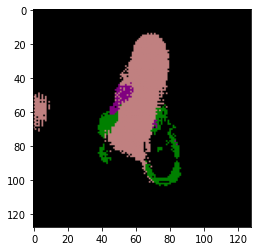

Ground truth


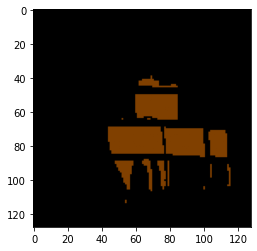

Prediction


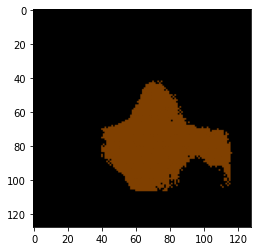

Ground truth


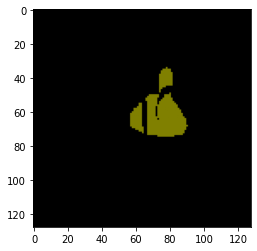

Prediction


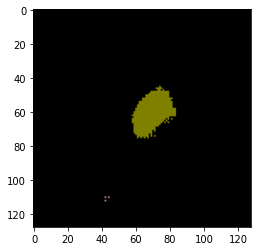

Ground truth


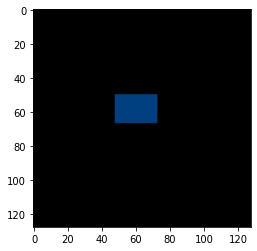

Prediction


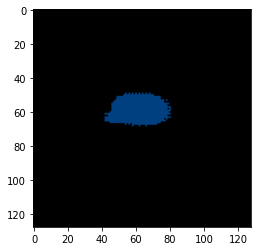

Ground truth


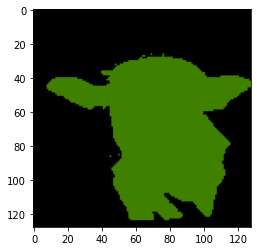

Prediction


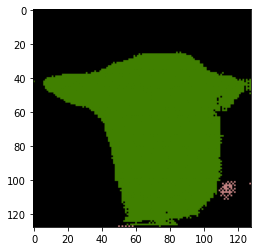

Ground truth


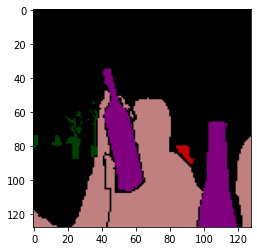

Prediction


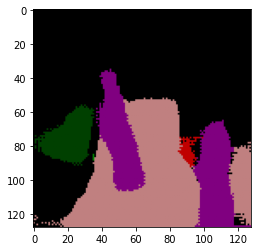

Ground truth


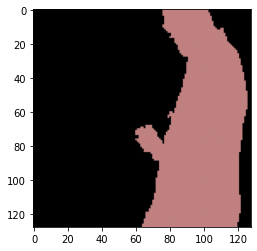

Prediction


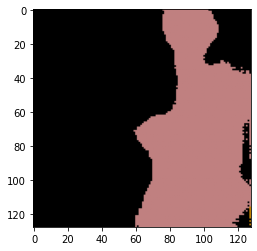

Ground truth


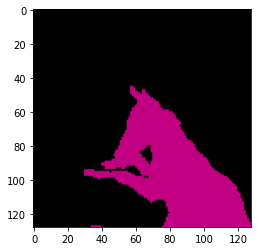

Prediction


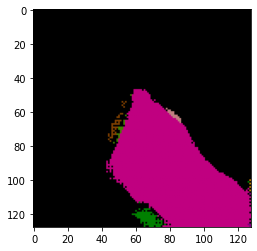

Ground truth


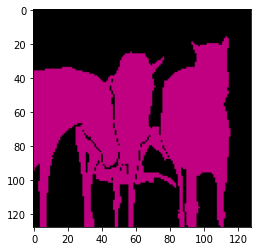

Prediction


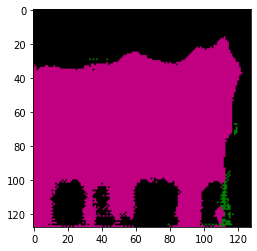

Ground truth


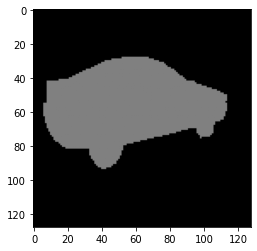

Prediction


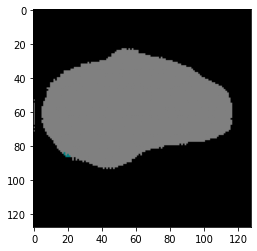

Ground truth


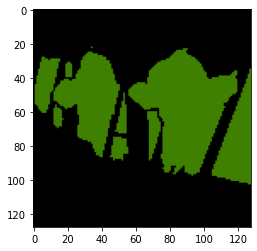

Prediction


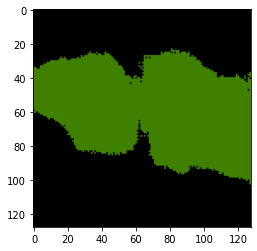

Ground truth


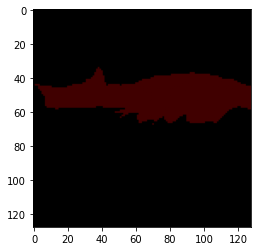

Prediction


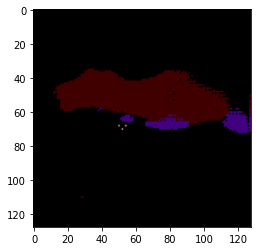

Ground truth


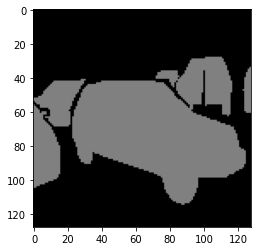

Prediction


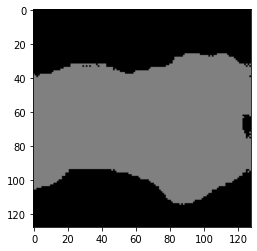

Ground truth


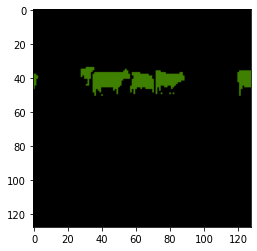

Prediction


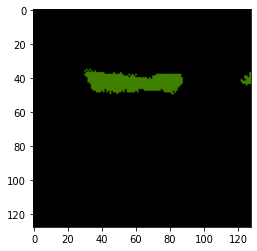

Ground truth


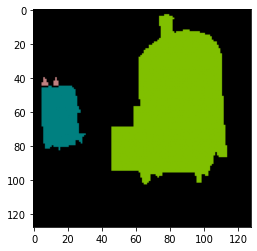

Prediction


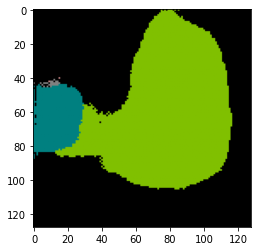

Ground truth


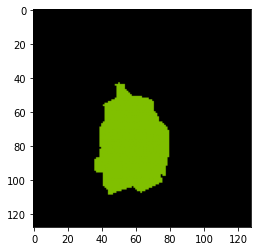

Prediction


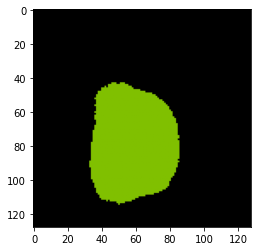

Ground truth


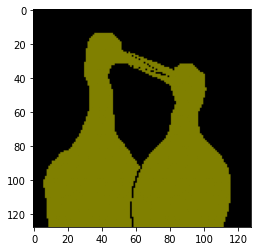

Prediction


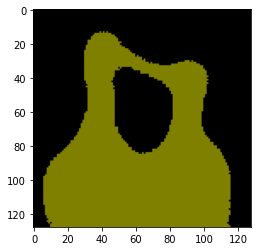

Ground truth


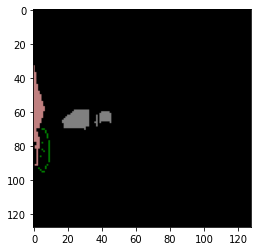

Prediction


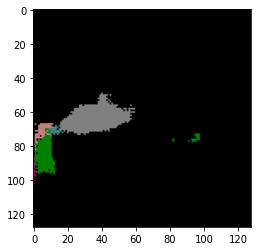

Ground truth


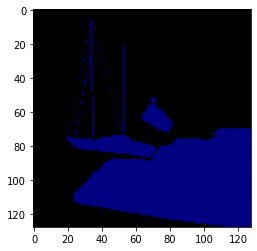

Prediction


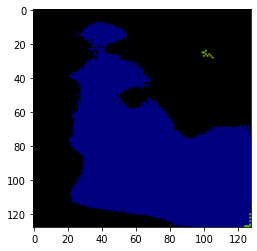

Ground truth


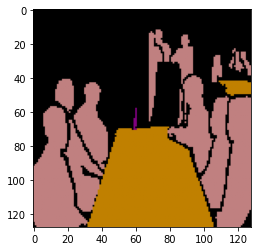

Prediction


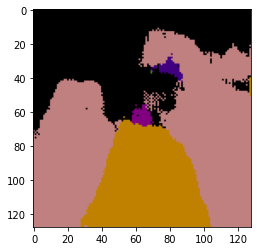

Ground truth


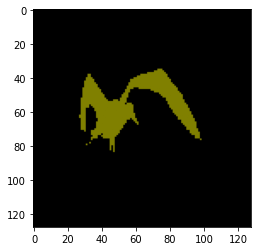

Prediction


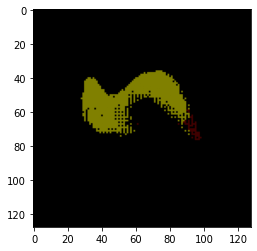

Ground truth


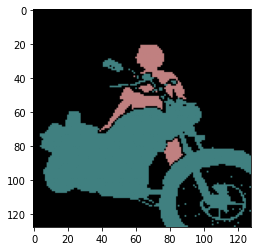

Prediction


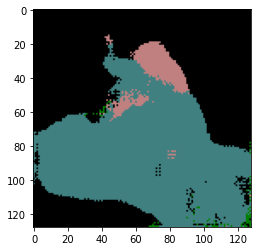

Ground truth


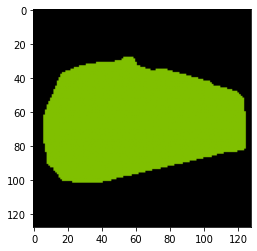

Prediction


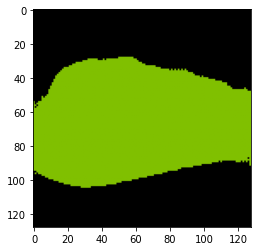

Ground truth


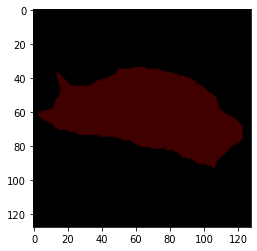

Prediction


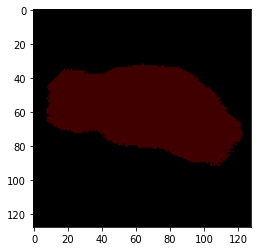

Ground truth


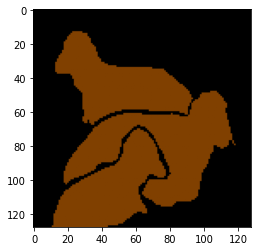

Prediction


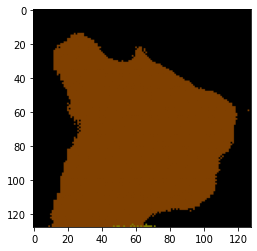

Ground truth


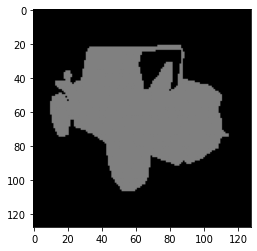

Prediction


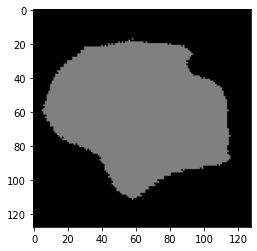

Ground truth


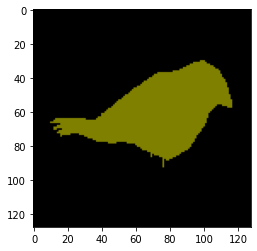

Prediction


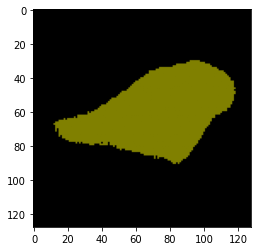

In [0]:
images, labels = next(image_segmentation_generator(32, logging=True))
predictions = trained_model.predict(images)

for i in range(len(labels)):
  print('Ground truth')
  plt.imshow(LayersToRGBImage(labels[i]))
  plt.show()
  print('Prediction')
  plt.imshow(LayersToRGBImage(predictions[i]))
  plt.show()

Alright! Progress! Still, huge overfitting. Instead of experimentation on regularization, let's first see which model(s) we should focus on. We'll do a full model comparison.

## For model comparisons

In [0]:
import pandas as pd

In [0]:
models_and_optimizers = [('PSPnet', pspnet(21), Adam(lr=1e-4, decay=1e-3)), ('U-net', unet(), Adam(lr=1e-4, decay=1e-3)), ('Res U-net', ResUNet(), Adam(lr=1e-4, decay=1e-3)), ('FCN', FCN(), Adam(lr=1e-4, decay=1e-3))]
training_history = {}
num_trials = 3

for model_name, model, optimizer in models_and_optimizers:

  val_acc = []
  val_mean_iou = []
  for _ in range(num_trials):

    weighted_loss = weighted_categorical_crossentropy(inverse_freq_class_weights)
    trained_model, history = train(model, loss=weighted_loss, optimizer=optimizer, epochs=25, validate=True)
    plot_history(history.history, model_name + ' Trial #{}'.format(_))

    # get val_accuracy and val_meaniou labels
    val_acc_label = [label for label in history.history.keys() if label.startswith('val_acc')][0]
    val_mean_iou_label = [label for label in history.history.keys() if label.startswith('val_mean')][0]

    best_acc_val = np.max(history.history[val_acc_label])
    best_mean_iou_val = np.max(history.history[val_mean_iou_label])

    val_acc.append(best_acc_val)
    val_mean_iou.append(best_mean_iou_val)
  
  training_history[model_name + ' val_acc'] = val_acc
  training_history[model_name + ' val_mean_iou'] = val_mean_iou
  pd.DataFrame(training_history).to_csv('/content/drive/My Drive/514project/training_history.csv')

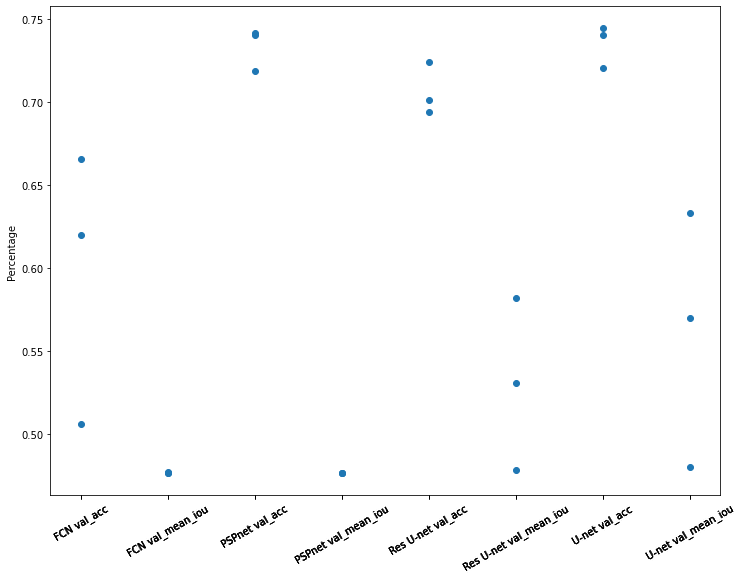

In [0]:
#@title
all_keys = sorted(list(training_history.keys()))
y_vals = []
x_vals = []
for key in all_keys:
  y_vals.extend(training_history[key])
  x_vals.extend([key] * num_trials)

plt.figure(figsize=(12, 9))
plt.scatter(x_vals, y_vals)
plt.xticks(x_vals, rotation=30)
plt.ylabel('Percentage')
print()

# For further reference, let's focus on the Mean IOU metric but not include the background class in that calculation

In [0]:
def new_mean_iou(y_true, y_pred, metric_name='iou', drop_last=True):
    """
    Compute mean metrics of two segmentation masks
    IoU(A,B) = |A & B| / (| A U B|)
    Args:
        drop_last = True: boolean flag to drop background class 
    Returns:
        IoU y_true and y_pred, as a float
    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """
    num_classes = K.shape(y_true)[-1]

    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    metric = iou

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')

    #drop the background
    if drop_last:
        metric = metric[:,1:]
        mask = mask[:,1:]

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)
    
    return K.mean(non_zero_sum / non_zero_count)

In [0]:
inverse_freq_class_weights = -np.log(weights_per_class / sum(weights_per_class))
trained_model = None
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  weighted_loss = weighted_categorical_crossentropy(inverse_freq_class_weights)
  trained_model, history = train(unet(), optimizer=Adam(lr=1e-4, decay=1e-3), loss=weighted_loss,
                                 metrics=['accuracy', MeanIoU(21), new_mean_iou],
                                 epochs=100, validate=True, show_progress=True)

  plot_history(history.history, "UNet")

# Comparing different loss functions

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 36s 392ms/step - loss: 3.6599 - accuracy: 0.3836 - mean_io_u: 0.4762 - val_loss: 3.6912 - val_accuracy: 0.7194 - val_mean_io_u: 0.4762
Epoch 2/25
92/92 [==============================] - 33s 354ms/step - loss: 3.4486 - accuracy: 0.5123 - mean_io_u: 0.4762 - val_loss: 3.8268 - val_accuracy: 0.6901 - val_mean_io_u: 0.4762
Epoch 3/25
92/92 [==============================] - 33s 354ms/step - loss: 3.3037 - accuracy: 0.5239 - mean_io_u: 0.4762 - val_loss: 3.7231 - val_accuracy: 0.5524 - val_mean_io_u: 0.4762
Epoch 4/25
92/92 [==============================] - 33s 353ms/step - loss: 3.1666 - accuracy: 0.5213 - mean_io_u: 0.4762 - val_loss: 3.6719 - val_accuracy: 0.4603 - val_mean_io_u: 0.4762
Epoch 5/25
92/92 [==============================] - 33s 356ms/step - loss: 3.0730 - accuracy: 0.5396 - mean_io_u: 0.4762 - val_loss: 3.4146 - val_accu

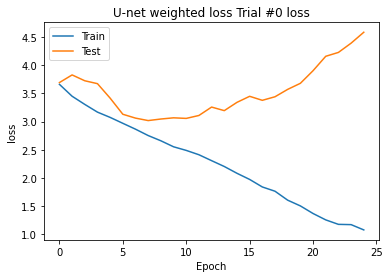

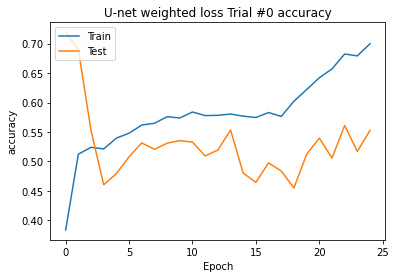

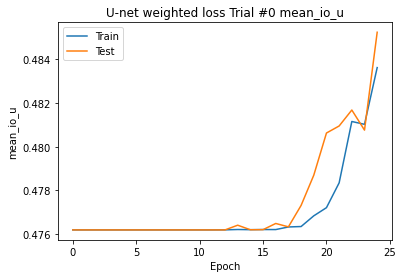

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 363ms/step - loss: 1.0103 - accuracy: 0.7177 - mean_io_u: 0.4879 - val_loss: 4.6390 - val_accuracy: 0.5651 - val_mean_io_u: 0.4875
Epoch 2/25
92/92 [==============================] - 33s 359ms/step - loss: 0.8683 - accuracy: 0.7369 - mean_io_u: 0.4918 - val_loss: 4.9716 - val_accuracy: 0.5909 - val_mean_io_u: 0.4962
Epoch 3/25
92/92 [==============================] - 33s 363ms/step - loss: 0.7667 - accuracy: 0.7569 - mean_io_u: 0.4949 - val_loss: 5.1366 - val_accuracy: 0.5898 - val_mean_io_u: 0.4929
Epoch 4/25
92/92 [==============================] - 33s 356ms/step - loss: 0.7456 - accuracy: 0.7604 - mean_io_u: 0.4985 - val_loss: 4.7226 - val_accuracy: 0.5986 - val_mean_io_u: 0.4877
Epoch 5/25
92/92 [==============================] - 33s 359ms/step - loss: 0.7058 - accuracy: 0.7671 - mean_io_u: 0.5014 - val_loss: 5.0206 - val_accu

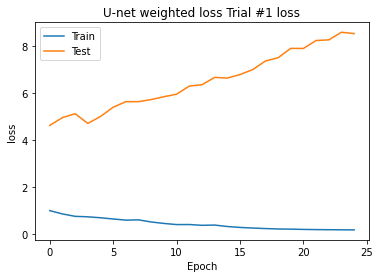

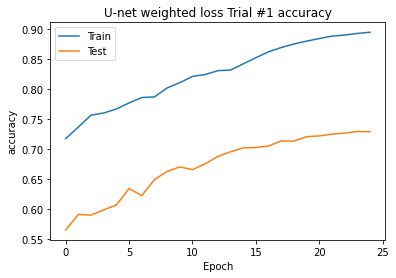

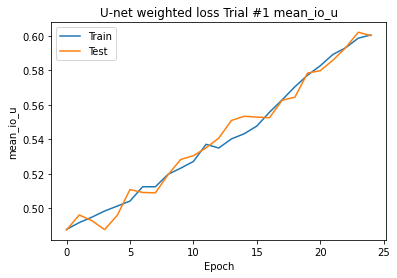

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 364ms/step - loss: 0.1791 - accuracy: 0.8994 - mean_io_u: 0.6040 - val_loss: 8.7405 - val_accuracy: 0.7254 - val_mean_io_u: 0.6061
Epoch 2/25
92/92 [==============================] - 33s 362ms/step - loss: 0.1752 - accuracy: 0.9008 - mean_io_u: 0.6132 - val_loss: 8.7793 - val_accuracy: 0.7293 - val_mean_io_u: 0.6036
Epoch 3/25
92/92 [==============================] - 33s 362ms/step - loss: 0.1701 - accuracy: 0.9030 - mean_io_u: 0.6150 - val_loss: 8.8266 - val_accuracy: 0.7274 - val_mean_io_u: 0.6051
Epoch 4/25
92/92 [==============================] - 33s 363ms/step - loss: 0.1698 - accuracy: 0.9038 - mean_io_u: 0.6212 - val_loss: 8.9824 - val_accuracy: 0.7316 - val_mean_io_u: 0.6114
Epoch 5/25
92/92 [==============================] - 33s 362ms/step - loss: 0.1643 - accuracy: 0.9054 - mean_io_u: 0.6255 - val_loss: 9.0473 - val_accu

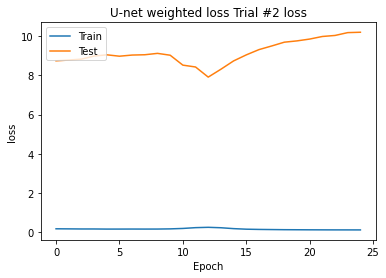

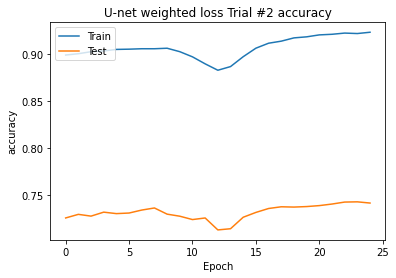

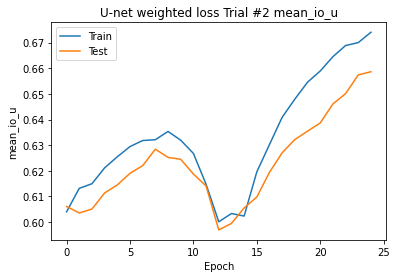

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 34s 369ms/step - loss: 1.5293 - accuracy: 0.6866 - mean_io_u: 0.5682 - val_loss: 1.3585 - val_accuracy: 0.7482 - val_mean_io_u: 0.4762
Epoch 2/25
92/92 [==============================] - 33s 362ms/step - loss: 1.1873 - accuracy: 0.7490 - mean_io_u: 0.4762 - val_loss: 1.2225 - val_accuracy: 0.7478 - val_mean_io_u: 0.4762
Epoch 3/25
92/92 [==============================] - 33s 360ms/step - loss: 1.1382 - accuracy: 0.7493 - mean_io_u: 0.4762 - val_loss: 1.1670 - val_accuracy: 0.7484 - val_mean_io_u: 0.4762
Epoch 4/25
92/92 [==============================] - 33s 360ms/step - loss: 1.0985 - accuracy: 0.7498 - mean_io_u: 0.4762 - val_loss: 1.1603 - val_accuracy: 0.7494 - val_mean_io_u: 0.4762
Epoch 5/25
92/92 [==============================] - 33s 360ms/step - loss: 1.0555 - accuracy: 0.7510 - mean_io_u: 0.4763 - val_loss: 1.1637 - val_accu

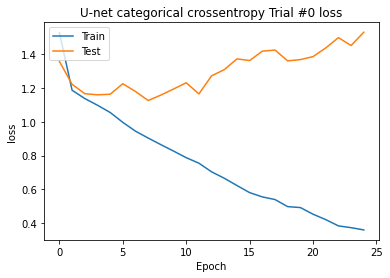

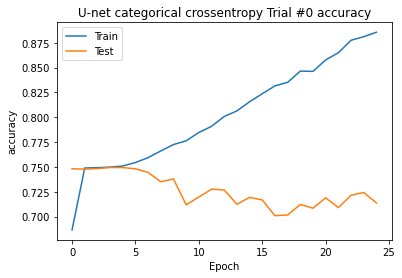

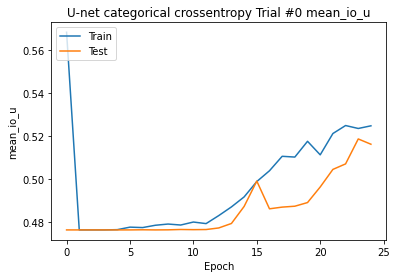

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 34s 366ms/step - loss: 0.3240 - accuracy: 0.8973 - mean_io_u: 0.5241 - val_loss: 1.5666 - val_accuracy: 0.7002 - val_mean_io_u: 0.4912
Epoch 2/25
92/92 [==============================] - 33s 360ms/step - loss: 0.2963 - accuracy: 0.9047 - mean_io_u: 0.5318 - val_loss: 1.5043 - val_accuracy: 0.7211 - val_mean_io_u: 0.4950
Epoch 3/25
92/92 [==============================] - 33s 360ms/step - loss: 0.2654 - accuracy: 0.9153 - mean_io_u: 0.5346 - val_loss: 1.5681 - val_accuracy: 0.7089 - val_mean_io_u: 0.4954
Epoch 4/25
92/92 [==============================] - 33s 359ms/step - loss: 0.2462 - accuracy: 0.9217 - mean_io_u: 0.5317 - val_loss: 1.6218 - val_accuracy: 0.7147 - val_mean_io_u: 0.5105
Epoch 5/25
92/92 [==============================] - 33s 360ms/step - loss: 0.2392 - accuracy: 0.9237 - mean_io_u: 0.5413 - val_loss: 1.6426 - val_accu

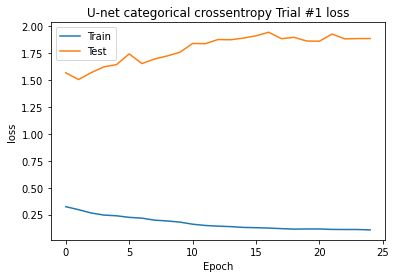

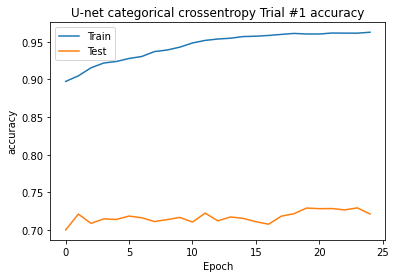

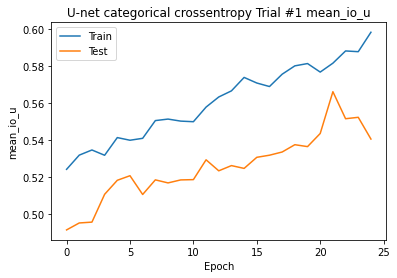

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 361ms/step - loss: 0.1045 - accuracy: 0.9635 - mean_io_u: 0.5721 - val_loss: 1.9696 - val_accuracy: 0.7355 - val_mean_io_u: 0.5595
Epoch 2/25
92/92 [==============================] - 33s 355ms/step - loss: 0.1024 - accuracy: 0.9642 - mean_io_u: 0.6038 - val_loss: 2.0630 - val_accuracy: 0.7270 - val_mean_io_u: 0.5604
Epoch 3/25
92/92 [==============================] - 33s 354ms/step - loss: 0.1022 - accuracy: 0.9640 - mean_io_u: 0.6045 - val_loss: 2.0272 - val_accuracy: 0.7217 - val_mean_io_u: 0.5475
Epoch 4/25
92/92 [==============================] - 32s 353ms/step - loss: 0.1009 - accuracy: 0.9644 - mean_io_u: 0.6074 - val_loss: 1.9882 - val_accuracy: 0.7136 - val_mean_io_u: 0.5365
Epoch 5/25
92/92 [==============================] - 33s 355ms/step - loss: 0.1032 - accuracy: 0.9635 - mean_io_u: 0.6074 - val_loss: 1.9721 - val_accu

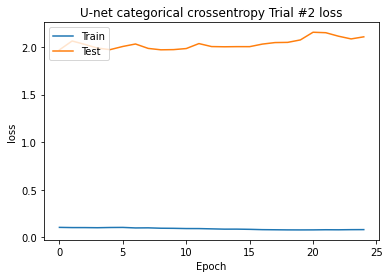

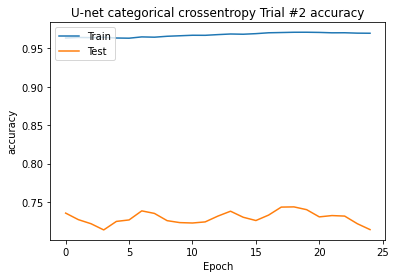

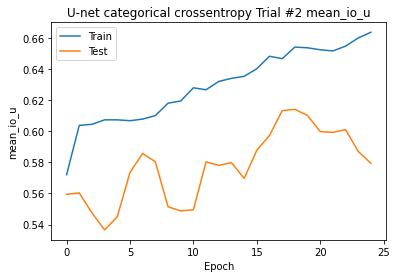

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 362ms/step - loss: 0.6026 - accuracy: 0.6806 - mean_io_u: 0.6557 - val_loss: 0.5036 - val_accuracy: 0.7482 - val_mean_io_u: 0.7858
Epoch 2/25
92/92 [==============================] - 33s 354ms/step - loss: 0.5020 - accuracy: 0.7490 - mean_io_u: 0.7869 - val_loss: 0.5044 - val_accuracy: 0.7478 - val_mean_io_u: 0.7861
Epoch 3/25
92/92 [==============================] - 33s 355ms/step - loss: 0.5015 - accuracy: 0.7492 - mean_io_u: 0.7871 - val_loss: 0.5033 - val_accuracy: 0.7483 - val_mean_io_u: 0.7865
Epoch 4/25
92/92 [==============================] - 32s 352ms/step - loss: 0.5017 - accuracy: 0.7491 - mean_io_u: 0.7870 - val_loss: 0.5033 - val_accuracy: 0.7484 - val_mean_io_u: 0.7865
Epoch 5/25
92/92 [==============================] - 33s 353ms/step - loss: 0.5030 - accuracy: 0.7485 - mean_io_u: 0.7866 - val_loss: 0.5042 - val_accu

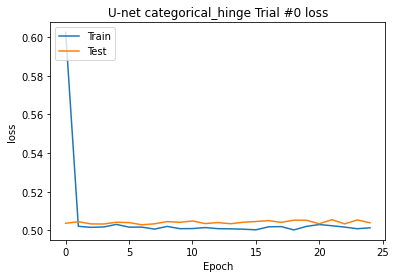

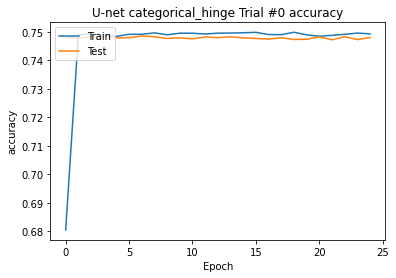

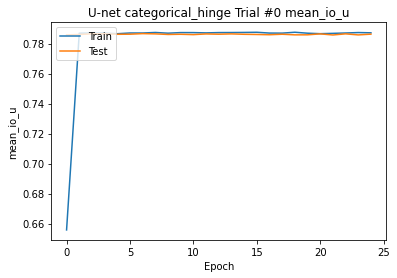

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 362ms/step - loss: 0.5010 - accuracy: 0.7495 - mean_io_u: 0.7868 - val_loss: 0.5036 - val_accuracy: 0.7482 - val_mean_io_u: 0.7864
Epoch 2/25
92/92 [==============================] - 33s 355ms/step - loss: 0.5020 - accuracy: 0.7490 - mean_io_u: 0.7869 - val_loss: 0.5044 - val_accuracy: 0.7478 - val_mean_io_u: 0.7861
Epoch 3/25
92/92 [==============================] - 33s 357ms/step - loss: 0.5015 - accuracy: 0.7492 - mean_io_u: 0.7871 - val_loss: 0.5033 - val_accuracy: 0.7483 - val_mean_io_u: 0.7865
Epoch 4/25
92/92 [==============================] - 33s 358ms/step - loss: 0.5017 - accuracy: 0.7491 - mean_io_u: 0.7870 - val_loss: 0.5033 - val_accuracy: 0.7484 - val_mean_io_u: 0.7865
Epoch 5/25
92/92 [==============================] - 33s 354ms/step - loss: 0.5030 - accuracy: 0.7485 - mean_io_u: 0.7866 - val_loss: 0.5042 - val_accu

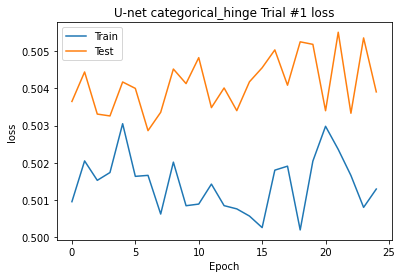

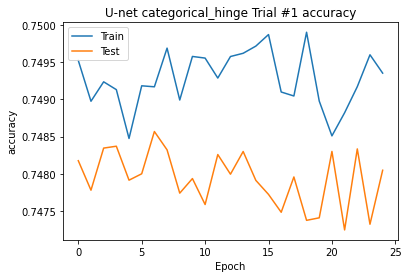

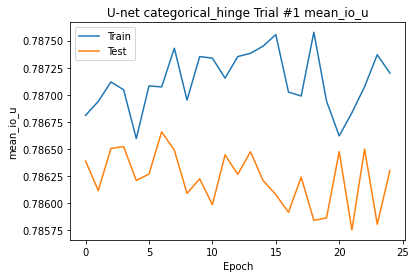

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 34s 364ms/step - loss: 0.5010 - accuracy: 0.7495 - mean_io_u: 0.7868 - val_loss: 0.5036 - val_accuracy: 0.7482 - val_mean_io_u: 0.7864
Epoch 2/25
92/92 [==============================] - 33s 354ms/step - loss: 0.5020 - accuracy: 0.7490 - mean_io_u: 0.7869 - val_loss: 0.5044 - val_accuracy: 0.7478 - val_mean_io_u: 0.7861
Epoch 3/25
92/92 [==============================] - 33s 355ms/step - loss: 0.5015 - accuracy: 0.7492 - mean_io_u: 0.7871 - val_loss: 0.5033 - val_accuracy: 0.7483 - val_mean_io_u: 0.7865
Epoch 4/25
92/92 [==============================] - 33s 356ms/step - loss: 0.5017 - accuracy: 0.7491 - mean_io_u: 0.7870 - val_loss: 0.5033 - val_accuracy: 0.7484 - val_mean_io_u: 0.7865
Epoch 5/25
92/92 [==============================] - 33s 354ms/step - loss: 0.5030 - accuracy: 0.7485 - mean_io_u: 0.7866 - val_loss: 0.5042 - val_accu

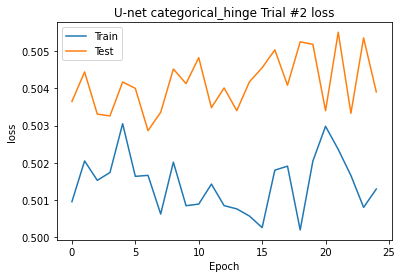

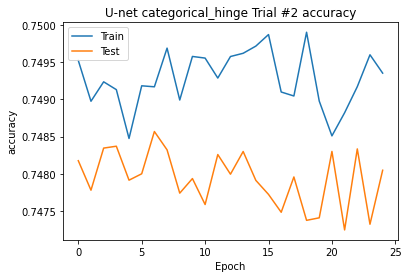

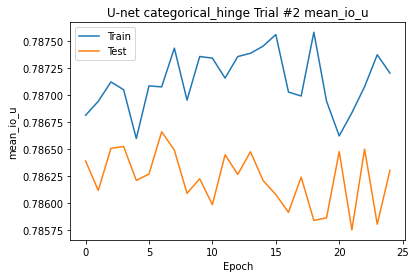

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 359ms/step - loss: 1.4489 - accuracy: 0.7151 - mean_io_u: 0.6470 - val_loss: 1.3794 - val_accuracy: 0.7482 - val_mean_io_u: 0.4762
Epoch 2/25
92/92 [==============================] - 32s 351ms/step - loss: 1.1757 - accuracy: 0.7487 - mean_io_u: 0.4762 - val_loss: 1.2209 - val_accuracy: 0.7478 - val_mean_io_u: 0.4762
Epoch 3/25
92/92 [==============================] - 32s 352ms/step - loss: 1.1276 - accuracy: 0.7494 - mean_io_u: 0.4762 - val_loss: 1.1752 - val_accuracy: 0.7483 - val_mean_io_u: 0.4762
Epoch 4/25
92/92 [==============================] - 32s 351ms/step - loss: 1.0878 - accuracy: 0.7500 - mean_io_u: 0.4763 - val_loss: 1.1432 - val_accuracy: 0.7488 - val_mean_io_u: 0.4762
Epoch 5/25
92/92 [==============================] - 32s 350ms/step - loss: 1.0410 - accuracy: 0.7503 - mean_io_u: 0.4777 - val_loss: 1.1420 - val_accu

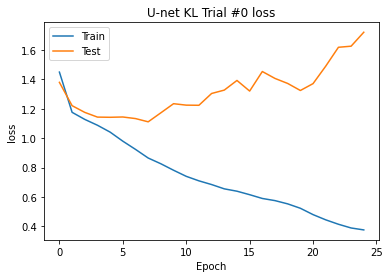

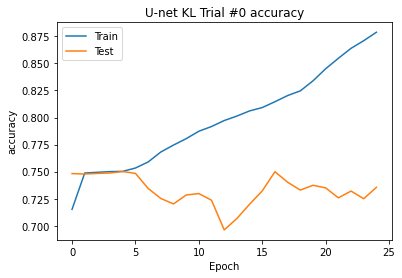

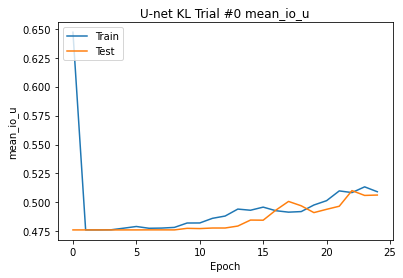

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 361ms/step - loss: 0.3706 - accuracy: 0.8813 - mean_io_u: 0.5117 - val_loss: 1.5176 - val_accuracy: 0.7063 - val_mean_io_u: 0.4858
Epoch 2/25
92/92 [==============================] - 32s 351ms/step - loss: 0.3222 - accuracy: 0.8939 - mean_io_u: 0.5142 - val_loss: 1.5794 - val_accuracy: 0.7141 - val_mean_io_u: 0.4822
Epoch 3/25
92/92 [==============================] - 33s 356ms/step - loss: 0.2997 - accuracy: 0.9020 - mean_io_u: 0.5217 - val_loss: 1.5619 - val_accuracy: 0.7025 - val_mean_io_u: 0.4863
Epoch 4/25
92/92 [==============================] - 33s 355ms/step - loss: 0.3010 - accuracy: 0.9010 - mean_io_u: 0.5118 - val_loss: 1.6095 - val_accuracy: 0.7183 - val_mean_io_u: 0.4882
Epoch 5/25
92/92 [==============================] - 33s 355ms/step - loss: 0.2863 - accuracy: 0.9061 - mean_io_u: 0.5234 - val_loss: 1.5878 - val_accu

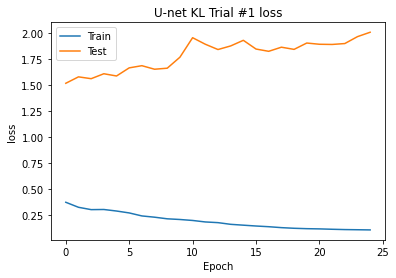

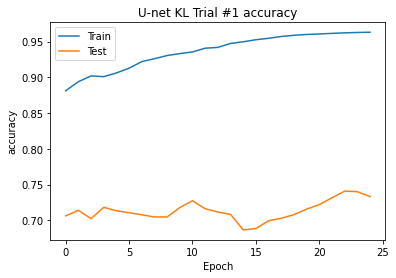

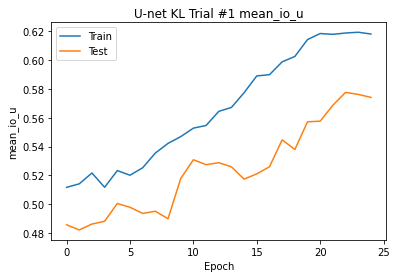

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/25
92/92 [==============================] - 33s 360ms/step - loss: 0.1035 - accuracy: 0.9629 - mean_io_u: 0.5981 - val_loss: 2.0125 - val_accuracy: 0.7081 - val_mean_io_u: 0.5445
Epoch 2/25
92/92 [==============================] - 33s 354ms/step - loss: 0.0977 - accuracy: 0.9649 - mean_io_u: 0.6294 - val_loss: 2.0479 - val_accuracy: 0.7074 - val_mean_io_u: 0.5490
Epoch 3/25
92/92 [==============================] - 33s 355ms/step - loss: 0.0982 - accuracy: 0.9645 - mean_io_u: 0.6356 - val_loss: 2.0209 - val_accuracy: 0.7126 - val_mean_io_u: 0.5570
Epoch 4/25
92/92 [==============================] - 33s 356ms/step - loss: 0.0977 - accuracy: 0.9647 - mean_io_u: 0.6339 - val_loss: 1.9869 - val_accuracy: 0.7308 - val_mean_io_u: 0.5897
Epoch 5/25
92/92 [==============================] - 33s 355ms/step - loss: 0.0981 - accuracy: 0.9645 - mean_io_u: 0.6372 - val_loss: 2.0443 - val_accu

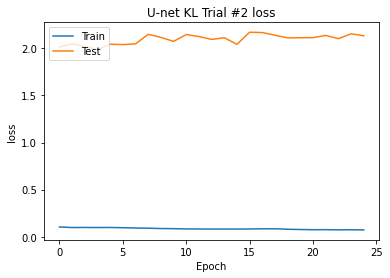

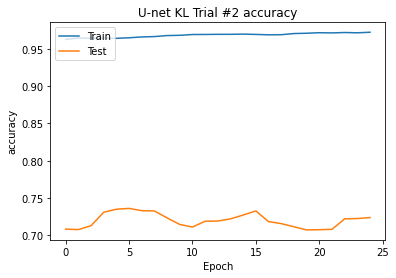

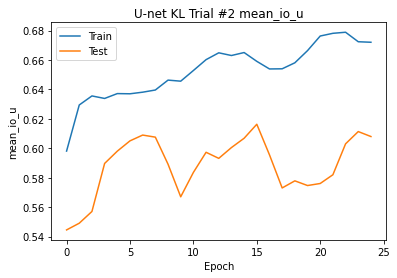

In [28]:
models_and_optimizers = [('U-net weighted loss', unet(), weighted_categorical_crossentropy(inverse_freq_class_weights), Adam(lr=1e-4, decay=1e-3)),
                         ('U-net categorical crossentropy', unet(), 'categorical_crossentropy', Adam(lr=1e-4, decay=1e-3)),
                         ('U-net categorical_hinge', unet(), 'categorical_hinge', Adam(lr=1e-4, decay=1e-3)),
                         ('U-net KL', unet(), tf.keras.losses.KLDivergence(), Adam(lr=1e-4, decay=1e-3))]
training_history = {}
num_trials = 3

for model_name, model, loss, optimizer in models_and_optimizers:
  val_acc = []
  val_mean_iou = []
  for _ in range(num_trials):

    weighted_loss = weighted_categorical_crossentropy(inverse_freq_class_weights)
    strategy = tf.distribute.MirroredStrategy()
    train_model = None
    
    trained_model, history = train(model, loss=loss, optimizer=optimizer, epochs=25, validate=True)
    plot_history(history.history, model_name + ' Trial #{}'.format(_))

    # get val_accuracy and val_meaniou labels
    val_acc_label = [label for label in history.history.keys() if label.startswith('val_acc')][0]
    val_mean_iou_label = [label for label in history.history.keys() if label.startswith('val_mean')][0]

    best_acc_val = np.max(history.history[val_acc_label])
    best_mean_iou_val = np.max(history.history[val_mean_iou_label])

    val_acc.append(best_acc_val)
    val_mean_iou.append(best_mean_iou_val)
  
  training_history[model_name + ' val_acc'] = val_acc
  training_history[model_name + ' val_mean_iou'] = val_mean_iou
  pd.DataFrame(training_history).to_csv('/content/drive/My Drive/514project/training_history.csv')

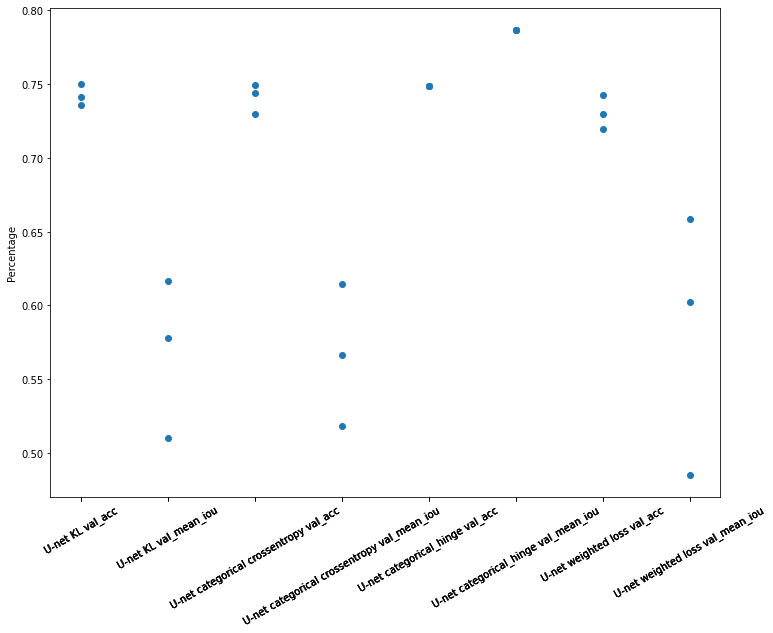

In [29]:
#@title
training_history
all_keys = sorted(list(training_history.keys()))
y_vals = []
x_vals = []
for key in all_keys:
  y_vals.extend(training_history[key])
  x_vals.extend([key] * num_trials)

plt.figure(figsize=(12, 9))
plt.scatter(x_vals, y_vals)
plt.xticks(x_vals, rotation=30)
plt.ylabel('Percentage')
print()